# Loading and Preparing Data



In [ ]:
# Import libraries
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import KFold
from numpy import mean
from numpy import std

We can load the MNIST dataset using the Keras API.

11490434/11490434 [==============================] - 0s 0us/step


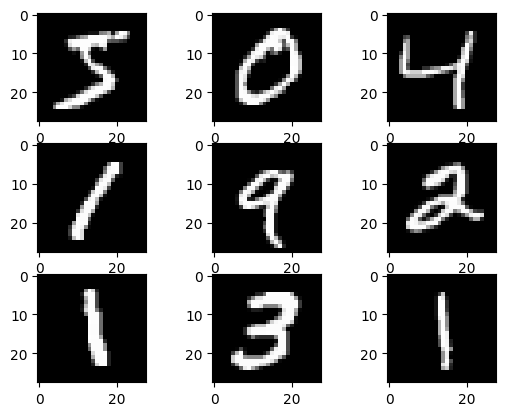

In [ ]:
# Load dataset
(trainX, trainY), (testX, testY) = mnist.load_data() # 60k training samples, 10k test samples

# Plot images
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
plt.show()

The images in the MNIST dataset are all greyscale, so each pixel only has one colour value. We are going to reshape our data so reflect the fact that our data has a single colour channel.

In [ ]:
# Shape before: (# samples, 28, 28)
# Shape after:  (# samples, 28, 28, 1)
# The 1 represents the single colour channel we have (brightness)
# If the data had, for example, RBG values, there would be three colour channels
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

Looking at the output, we see that there are 10 classes (digits 0 to 9) in a single column. We are going to switch to a one-hot encoding (i.e., a column for each class, where the value is 1 if that is the digit shown, and 0 if not).

In [ ]:
# One-hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [ ]:
# Load training and test dataset
def load_dataset():
	# Load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# Reshape dataset to have a single colour channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# One-hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

Next, we need to normalize the data. Currently, the pixel values are between 0 and 255. Let's rescale to be between 0 and 1, and wrap that in a function.

In [ ]:
# Scales pixels
def prep_pixels(train, test):
	# Convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# Normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	return train_norm, test_norm

# Defining the Model

In [ ]:
# Define CNN model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
# Evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# Prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# Enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# Define model
		model = define_model()
		# Select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# Fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# Evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# Store scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

In [ ]:
# Plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# Plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# Plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

In [ ]:
# Summarize model performance
def summarize_performance(scores):
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	plt.boxplot(scores)
	plt.show()

In [ ]:
# Run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

> 98.500
> 98.758
> 98.642
> 98.808
> 98.700


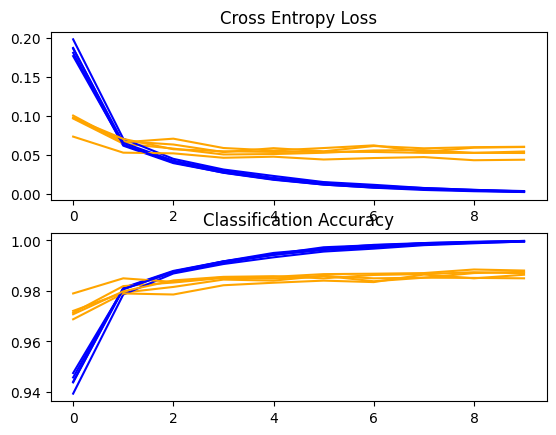

Accuracy: mean=98.682 std=0.107, n=5


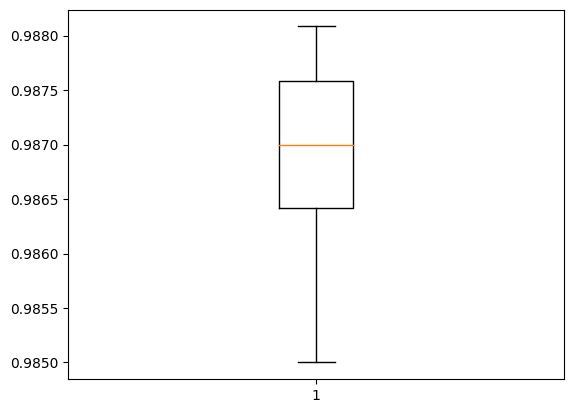

In [ ]:
run_test_harness()